<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Structure-cheat-sheet" data-toc-modified-id="Structure-cheat-sheet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Structure cheat sheet</a></span></li><li><span><a href="#Data-structure" data-toc-modified-id="Data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data structure</a></span></li><li><span><a href="#get-features" data-toc-modified-id="get-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get features</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Scaling" data-toc-modified-id="Scaling-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PCA</a></span></li></ul></li><li><span><a href="#Unsupervised-Clustering" data-toc-modified-id="Unsupervised-Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Unsupervised Clustering</a></span></li></ul></div>

# Basics

## Structure cheat sheet

1. func: train data lead (following order)
    1. read the descriptive dataframe from the feature-pipeline
    2. extract feature from the feature-objects which are labeled train-dataset from dataframe
    3. create numpy feature array for the processing pipeline
2. preprocessing
    1. Transformation (any combination of the following)
        + log-transform
        + PCA
        + others
    2. Scaling (one of the following)
        + StandardScaler
        + MinMaxScaler
3. Unsupervised Clustering
    1. Estimate initial hyperparameter
    2. Create grid over various hyperparameters
    3. Train all and choose the best according to metric
    
    
in all steps the cluster-recorder object (possibly dataframe-row) will record all the meta-information like hyper-parameters

## Data structure

There are multiple degrees of freedom in the data:

1. Signal to noise ratio (SNR)
2. Machine type
    1. pump
    2. fan
    3. valve (solenoid)
    4. slider
3. Machine ID
    1. four different machine IDs
    
The pipeline will be applied to fixed SNR, fixed machine type and fixed ID

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
sns.set()

BASE_FOLDER = '../../'
%run -i ..\..\utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i ..\..\utility\modeling\JupyterLoad_modeling.py

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd


## get features

Get the descriptive dataframe for the features.

The descriptive dataframe contains all IDs of the pump. We will focus on ID '00' for now since the modeling phase is seperated per SNR, per machine, per ID anyway.

In [17]:
del df_descr

In [18]:
path_descr = '.\..\..\dataset\MEL_to_Pandas\data_6dB_pump\FEpandas_MELv1_nm80_ch0.pkl'
ID = '00'
# loading time feature extractor: 4:37
if 'df_descr' in dir():
    pass
else:
    df_descr, data = load_data(path_descr, feat='MELv1_nm80_ch0', ID=ID, machine='pump', SNR='6dB', train_set=False)
    data.shape

100%|██████████| 863/863 [01:26<00:00,  9.99it/s]


## Preprocessing

### Scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

### PCA

In [20]:
from sklearn.decomposition import PCA

# instantiate pca
n_prin_comp = 862
pca = PCA(n_components=n_prin_comp, svd_solver='full')

data_pc = pca.fit_transform(data)

In [5]:
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(range(1,n_prin_comp+1), np.cumsum(pca.explained_variance_ratio_)
                , label='PSD of pump_id_{00}'.format(ID))
plt.xlabel('principal component')
plt.ylabel('cumulated explained variance ratio')
plt.legend()
plt.show()

NameError: name 'ID' is not defined

## Unsupervised Clustering

In [6]:
from sklearn.cluster import KMeans

args = [{'n_clusters': num_clusters,
         'init': 'k-means++',
         'n_jobs': -1}
        for num_clusters in range(2, 15)]
model = KMeans()

best_clusters, best_args, score = evaluate_clustering(
        model, args, data, metric='db_score')

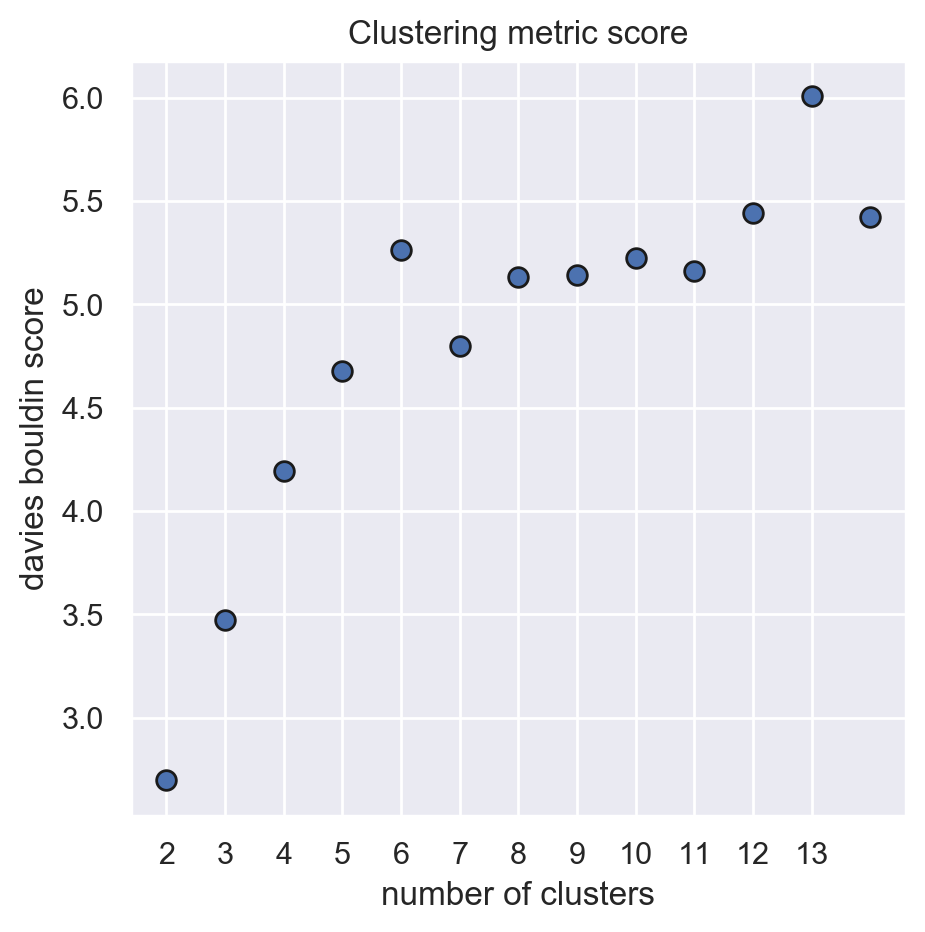

In [7]:
evaluate_args(score, args, score_label='davies bouldin score')

In [8]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(random_state = 0).fit(data_pc)
# Now we can use predict method. It will return 1 for an inlier and -1 for an outlier.
#cov.predict()

In [23]:
path_descr = './../../dataset/MEL_to_Pandas/data_6dB_pump/FEpandas_MELv1_nm80_ch0.pkl'

# loading time feature extractor: 4:37
df_descr_test, data_test = load_data(path_descr, train_set=False)

100%|██████████| 286/286 [00:09<00:00, 29.85it/s]


In [24]:
data_test = scaler.transform(data_test)
data_test = pca.transform(data_test)
prediction = cov.predict(data_test)

In [25]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
data_test.shape

(286, 862)

In [30]:
data_pc.shape

(863, 862)